In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from PIL import Image
from skimage.io import imread, imshow
import umap.umap_ as umap

In [25]:
train_path = "/teamspace/studios/this_studio/Animal Classification Capstone Project (2)/DeepLearning/DeepLearning 24-25/Train"
labels = os.listdir(train_path)
labels_list = []
count = 0
for label in labels:
    labels_list.append(label)
    count += 1

print(f"we have {count} classes")
print(labels_list)

we have 7 classes
['Bear', 'Camel', 'Chiken', 'Elephent', 'Horse', 'Lion', 'Squirrel']


In [26]:
# Function to load dataset structure
data = []
for root, dirs, files in os.walk(train_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            label = os.path.basename(root)  # Assuming folder names are labels
            file_path = os.path.join(root, file)
            data.append((file_path, label))

image_data = pd.DataFrame(data, columns=['file_path', 'label'])


print(f"Total Images: {len(image_data)}")

Total Images: 2392


In [27]:
class_counts = Counter(image_data['label'])
print("Class Distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

Class Distribution:
Bear: 346
Camel: 353
Chiken: 346
Elephent: 337
Horse: 355
Lion: 340
Squirrel: 315


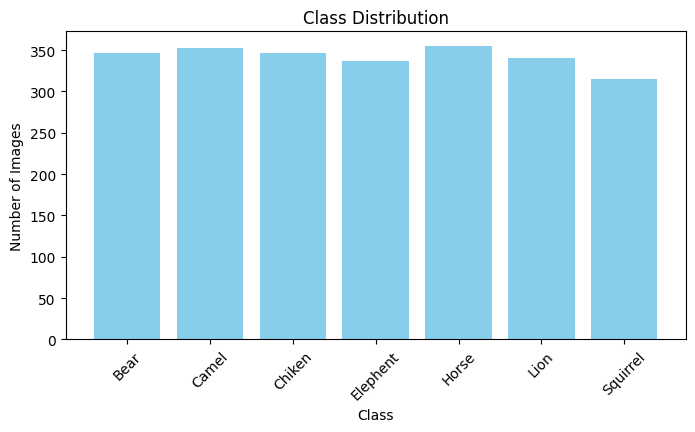

In [28]:
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [29]:
dimensions = []
for file_path in image_data['file_path']:
    try:
        with Image.open(file_path) as img:
            dimensions.append(img.size)  # (width, height)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

if dimensions:
    avg_width = sum([dim[0] for dim in dimensions]) / len(dimensions)
    avg_height = sum([dim[1] for dim in dimensions]) / len(dimensions)
    print(f"Average Image Dimensions: {int(avg_width)} x {int(avg_height)}")

Average Image Dimensions: 493 x 427


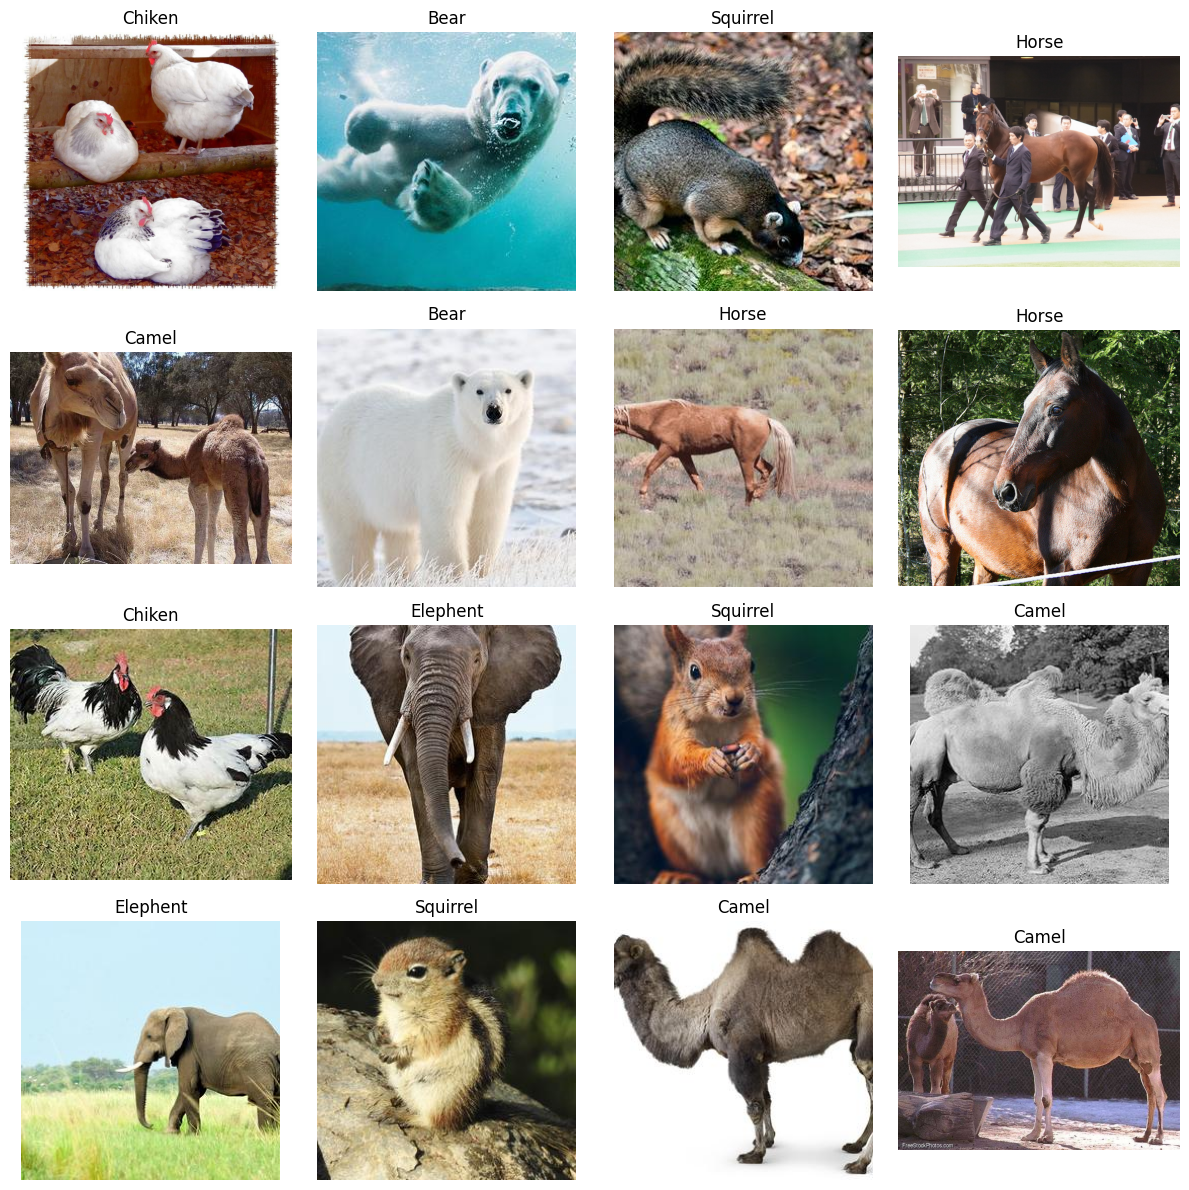

In [30]:
def visualize_sample_images(image_data, num_samples=16):
    sample_data = image_data.sample(min(num_samples, len(image_data)), random_state=42)
    plt.figure(figsize=(12, 12))
    for i, (file_path, label) in enumerate(zip(sample_data['file_path'], sample_data['label'])):
        try:
            with Image.open(file_path) as img:
                plt.subplot(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), i + 1)
                plt.imshow(img)
                plt.title(label)
                plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {file_path}: {e}")
    plt.tight_layout()
    plt.show()

# Call the function to visualize sample images
visualize_sample_images(image_data)

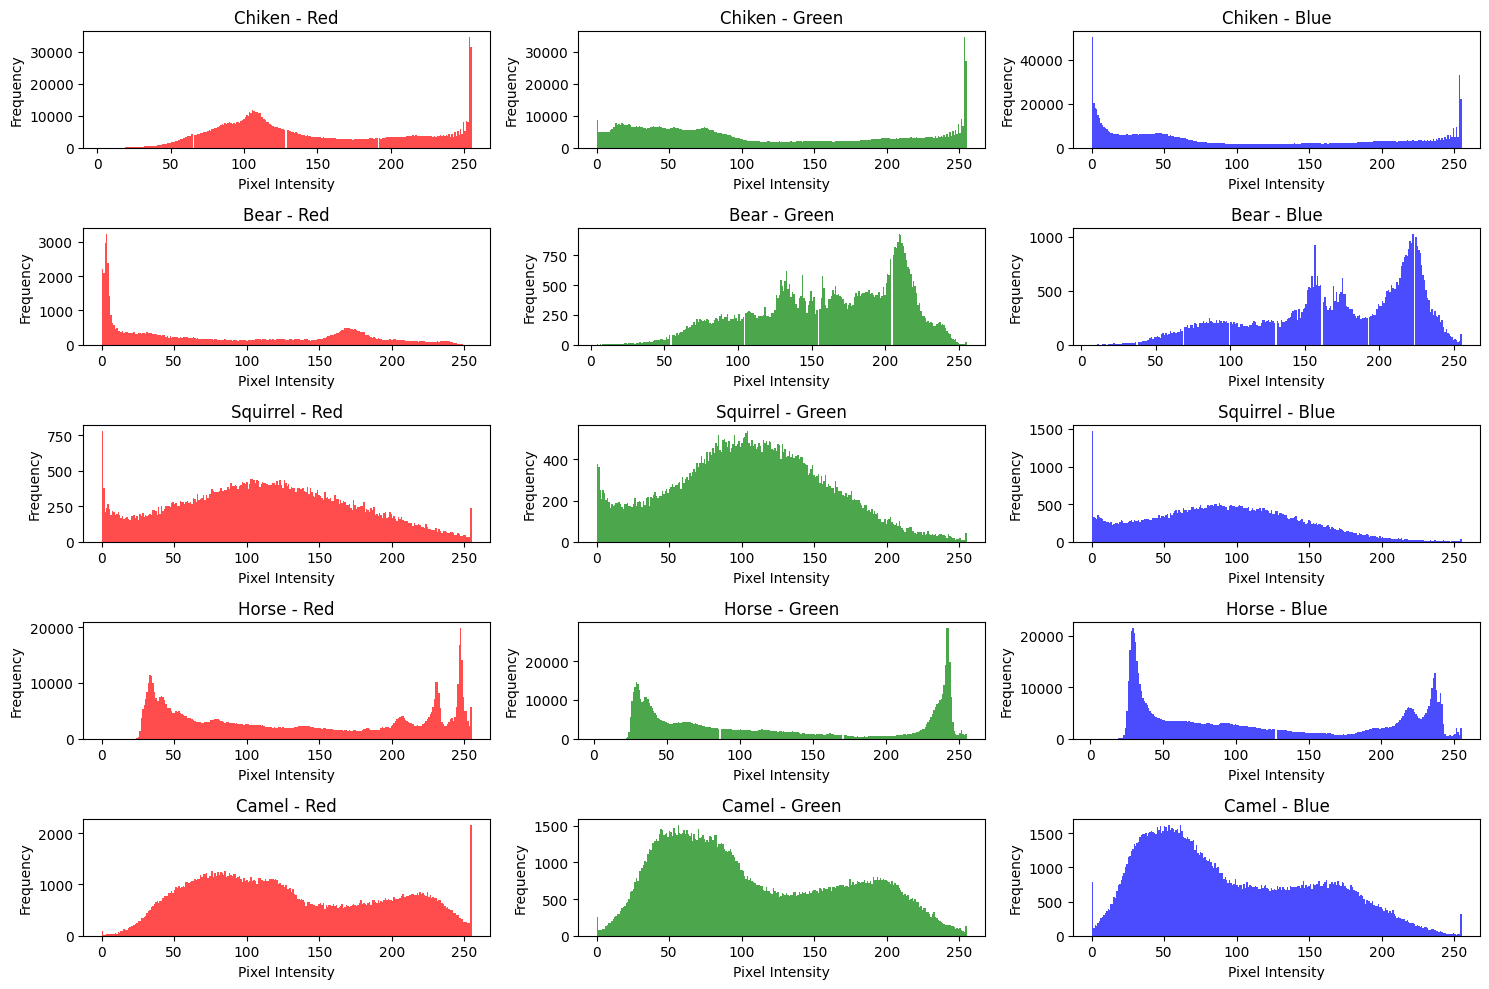

In [31]:
def plot_rgb_distributions(image_data, num_samples=5):
    sample_data = image_data.sample(min(num_samples, len(image_data)), random_state=42)
    plt.figure(figsize=(15, 10))
    for i, file_path in enumerate(sample_data['file_path']):
        try:
            with Image.open(file_path) as img:
                img_array = np.array(img)
                for channel, color in enumerate(['Red', 'Green', 'Blue']):
                    histogram = img_array[:, :, channel].flatten()
                    plt.subplot(num_samples, 3, i * 3 + channel + 1)
                    plt.hist(histogram, bins=256, color=color.lower(), alpha=0.7)
                    plt.title(f"{sample_data.iloc[i]['label']} - {color}")
                    plt.xlabel('Pixel Intensity')
                    plt.ylabel('Frequency')
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")
    plt.tight_layout()
    plt.show()

# Call the function to plot RGB distributions
plot_rgb_distributions(image_data)

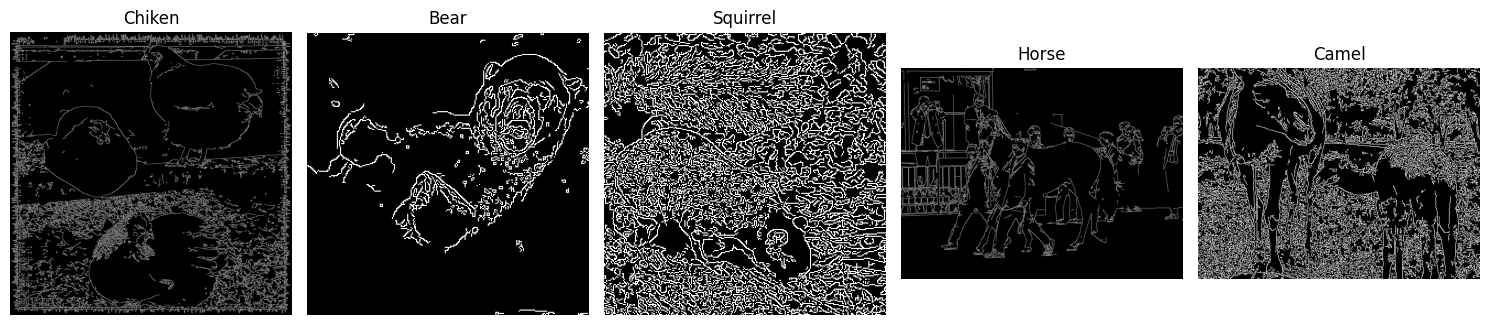

In [32]:
def plot_edge_detection(image_data, num_samples=5):
    sample_data = image_data.sample(min(num_samples, len(image_data)), random_state=42)
    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(sample_data['file_path']):
        try:
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            edges = cv2.Canny(img, 100, 200)
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(edges, cmap='gray')
            plt.title(sample_data.iloc[i]['label'])
            plt.axis('off')
        except Exception as e:
            print(f"Error processing image {file_path}: {e}")
    plt.tight_layout()
    plt.show()

plot_edge_detection(image_data)


Preparing data for UMAP...
Running UMAP...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


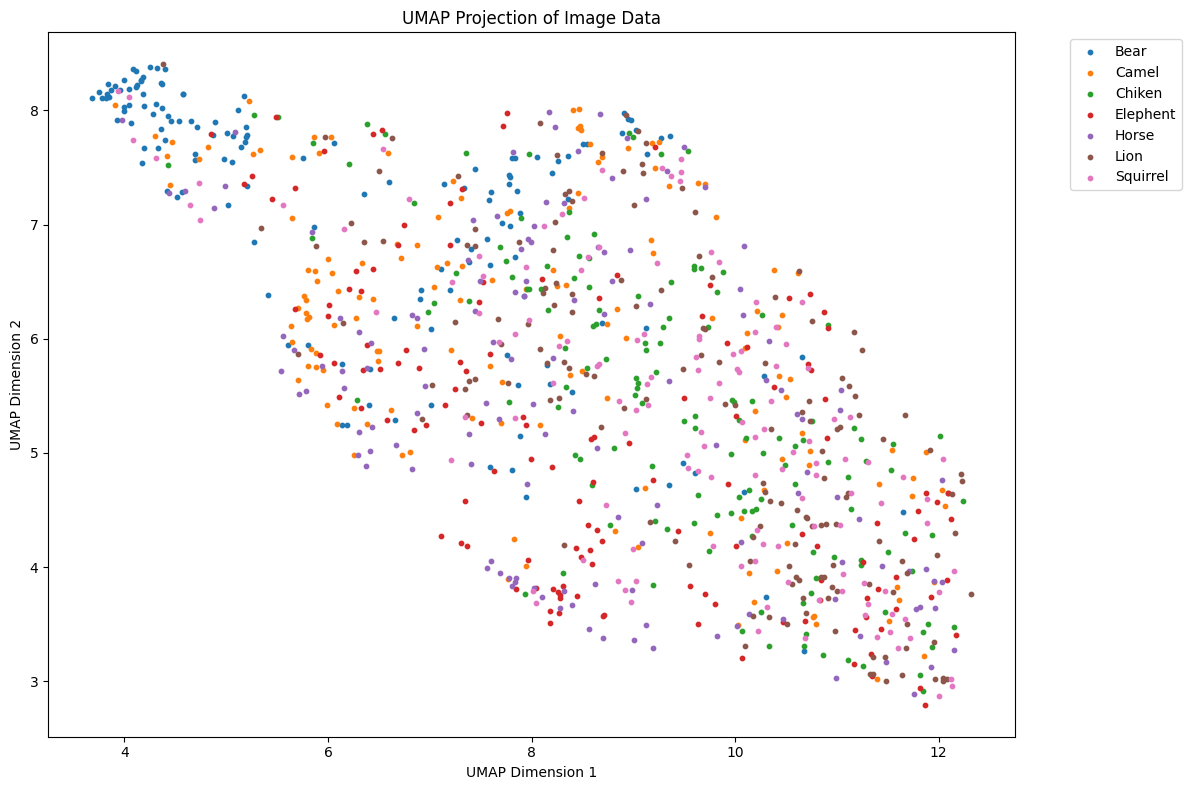

In [39]:
np.random.seed(5)
sample_size = 1000  # Adjust based on your system capabilities
sampled_data = image_data.sample(sample_size)

print("\nPreparing data for UMAP...")
target_size = (64, 64)
features = []
valid_labels = []

for file_path, label in zip(sampled_data['file_path'], sampled_data['label']):
    try:
        img = Image.open(file_path).convert('RGB').resize(target_size)
        features.append(np.array(img).flatten()/255.0)  # Normalize to [0,1]
        valid_labels.append(label)
    except:
        continue

print("Running UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(features)

# Plot UMAP results
plt.figure(figsize=(12,8))
for label in np.unique(valid_labels):
    mask = np.array(valid_labels) == label
    plt.scatter(embedding[mask,0], embedding[mask,1], label=label, s=10)
plt.title('UMAP Projection of Image Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()